## Data loading

In [1]:
%pylab inline
import cv2
import numpy as np
import dicom
import pandas as pd

/Users/lishen/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Populating the interactive namespace from numpy and matplotlib


In [3]:
from gzip import GzipFile

In [4]:
#mammo_content = dicom.read_file(GzipFile('./trainingData/000138.dcm.gz'))
#mammo_org = mammo_content.pixel_array

In [8]:
def gen_maxval_mask(dtype):
    '''Generate a maxval binary mask for a numpy uintX dtype
    '''
    if dtype not in [np.uint8, np.uint16, np.uint32, np.uint64]:
        raise Exception
    return np.array([-1]).astype(dtype)[0]

In [44]:
mammo_org = cv2.imread('./trainingData/jpg/000138.jpg', 
                       cv2.IMREAD_GRAYSCALE)
#mammo_resize = cv2.resize(mammo_org, dsize=None, 
#                          fx=.25, fy=.25, interpolation=cv2.INTER_CUBIC)
#mammo_resize.shape

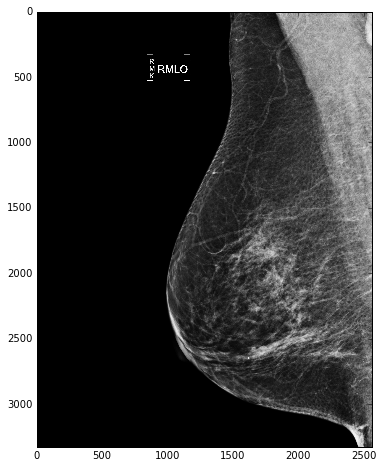

In [45]:
fig,ax = subplots()
fig.set_size_inches([6, 9])
ax.imshow(mammo_org, cmap='gray')

In [46]:
# This may be optional
def scale_image_01(img):
    return (img.astype(np.float64) - img.min()) / (img.max() - img.min())
#mammo_scaled = scale_image_01(mammo_org)
#fig,ax = subplots()
#fig.set_size_inches([6, 9])
#ax.imshow(mammo_scaled, cmap='gray')

## Median filtering (seems Optional)

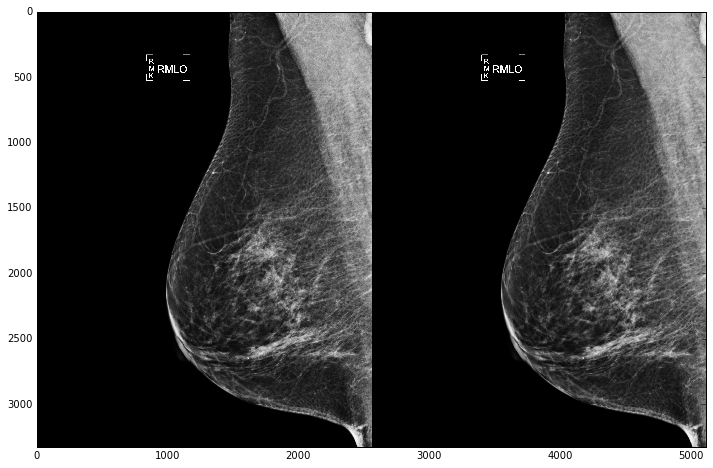

In [47]:
mammo_med_blurred = cv2.medianBlur(mammo_org, 3)  # <<= para to tune!
fig,ax = subplots()
fig.set_size_inches([12, 9])
res = hstack((mammo_org, mammo_med_blurred))
ax.imshow(res, cmap='gray')

## Radiopaque artifacts suppression

### Binarization

In [48]:
print mammo_med_blurred
print mammo_med_blurred.max()

[[  0   0   0 ...,   0   0   0]
 [  0   0   0 ...,   0   0   0]
 [  0   0   0 ...,   0   0   0]
 ..., 
 [  0   0   0 ..., 125 126 130]
 [  0   0   0 ..., 132 133 133]
 [  0   0   0 ..., 136 136 133]]
255


In [49]:
def convert_scale_alpha(maxval):
    return 255.0/maxval
    
#u16u8_alpha = convert_scale_alpha(mammo_med_blurred.max())
#print u16u8_alpha

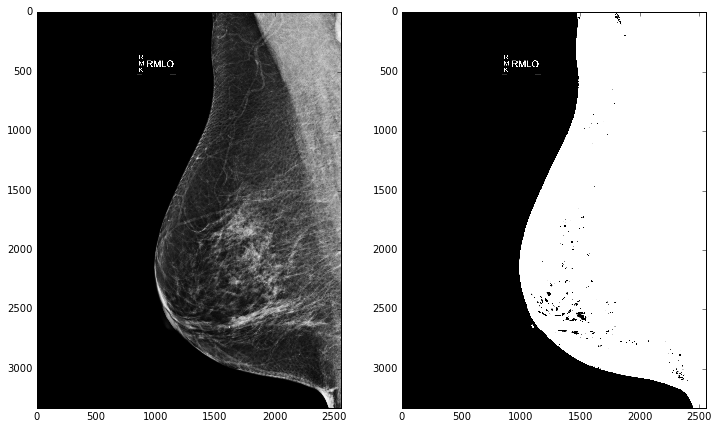

In [50]:
global_threshold = 18  # from Nagi thesis. <<= para to tune!
#mammo_med_blurred_col = cv2.cvtColor(mammo_med_blurred, cv2.COLOR_GRAY2BGR)
#mammo_med_blurred_u8 = cv2.convertScaleAbs(mammo_med_blurred, alpha=u16u8_alpha)
_, mammo_binary = cv2.threshold(mammo_med_blurred, global_threshold, 
                                maxval=255, type=cv2.THRESH_BINARY)
fig,axes = subplots(1, 2)
fig.set_size_inches([12, 9])
#res = hstack((mammo_med_blurred, mammo_binary))
axes[0].imshow(mammo_med_blurred, cmap='gray')
axes[1].imshow(mammo_binary, cmap='gray')

### Artifacts suppression

In [51]:
def select_largest_obj(img_bin, lab_val=255, fill_holes=False, 
                       smooth_boundary=False, kernel_size=15):
    '''Select the largest object from a binary image and optionally
    fill holes inside it and smooth its boundary.
    Args:
        img_bin(2D array): 2D numpy array of binary image.
        lab_val([int]): integer value used for the label of the largest 
                        object. Default is 255.
        fill_holes([boolean]): whether fill the holes inside the largest 
                               object or not. Default is false.
        smooth_boundary([boolean]): whether smooth the boundary of the 
                                    largest object using morphological 
                                    opening or not. Default is false.
        kernel_size([int]): the size of the kernel used for morphological 
                            operation.
    '''
    n_labels, img_labeled, lab_stats, _ = cv2.connectedComponentsWithStats(
        img_bin, connectivity=8, ltype=cv2.CV_32S)
    largest_obj_lab = np.argmax(lab_stats[1:, 4]) + 1
    largest_mask = np.zeros(img_bin.shape, dtype=np.uint8)
    largest_mask[img_labeled == largest_obj_lab] = lab_val
    if fill_holes:
        bkg_locs = where(img_labeled == 0)
        bkg_seed = (bkg_locs[0][0], bkg_locs[1][0])
        img_floodfill = largest_mask.copy()
        h_, w_ = largest_mask.shape
        mask_ = np.zeros((h_ + 2, w_ + 2), dtype=np.uint8)
        cv2.floodFill(img_floodfill, mask_, seedPoint=bkg_seed, newVal=lab_val)
        holes_mask = cv2.bitwise_not(img_floodfill)  # mask of the holes.
        largest_mask = largest_mask + holes_mask
    if smooth_boundary:
        kernel_ = np.ones((kernel_size, kernel_size), dtype=np.uint8)
        largest_mask = cv2.morphologyEx(largest_mask, cv2.MORPH_OPEN, kernel_)
        
    return largest_mask

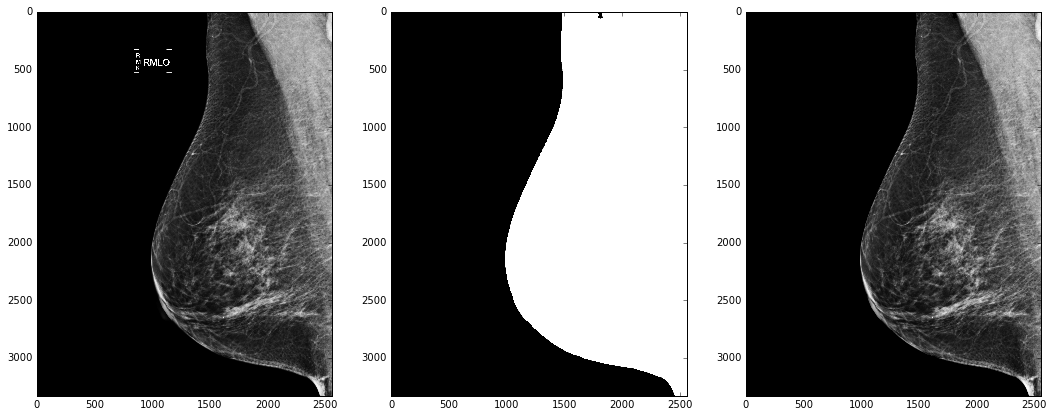

In [52]:
#u16_maxval = gen_maxval_mask(mammo_med_blurred.dtype)
mammo_breast_mask = select_largest_obj(mammo_binary, lab_val=255, 
                                       fill_holes=True, 
                                       smooth_boundary=True, kernel_size=15)  # <<= para to tune!
mammo_arti_suppr = cv2.bitwise_and(mammo_med_blurred, mammo_breast_mask)
fig,axes = subplots(1, 3)
fig.set_size_inches([18, 9])
axes[0].imshow(mammo_med_blurred, cmap='gray')
axes[1].imshow(mammo_breast_mask, cmap='gray')
axes[2].imshow(mammo_arti_suppr, cmap='gray')

## Pectoral muscle suppression

### Contrast enhancement

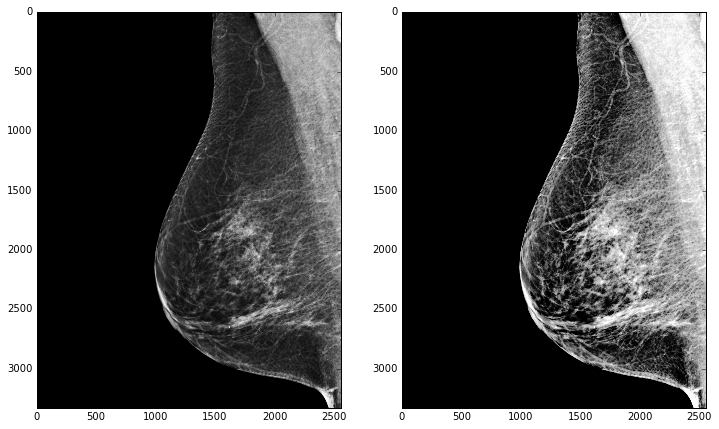

In [53]:
mammo_breast_equ = cv2.equalizeHist(mammo_arti_suppr)
fig,axes = subplots(1, 2)
fig.set_size_inches([12, 9])
axes[0].imshow(mammo_arti_suppr, cmap='gray')
axes[1].imshow(mammo_breast_equ, cmap='gray')

### Seeded flood fill (not work)

```python
seed_margin = 10
h, w = mammo_breast_equ.shape
srg_seed = (seed_margin, w - seed_margin)
print 'Seed intensity:', mammo_breast_equ[srg_seed]
mammo_pect_fill = mammo_breast_equ.copy()
mask_ = zeros((h + 2, w + 2), dtype=uint8)
diff_cutoff = 12  # the result is very sensitive to this parameter!!
cv2.floodFill(mammo_pect_fill, mask_, seedPoint=srg_seed, 
              newVal=0, loDiff=diff_cutoff, upDiff=diff_cutoff)
fig,ax = subplots()
fig.set_size_inches([6, 9])
ax.imshow(mammo_pect_fill, cmap='gray')
```

### Watershed segmentation

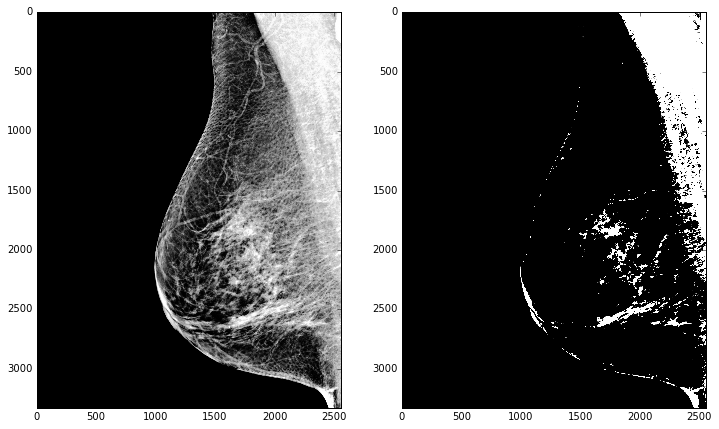

In [54]:
pect_high_inten_thres = 200  # <<= para to tune!
_, pect_binary_thres = cv2.threshold(mammo_breast_equ, pect_high_inten_thres, 
                                     maxval=255, type=cv2.THRESH_BINARY)
fig,axes = subplots(1, 2)
fig.set_size_inches([12, 9])
#res = hstack((mammo_med_blurred, mammo_binary))
axes[0].imshow(mammo_breast_equ, cmap='gray')
axes[1].imshow(pect_binary_thres, cmap='gray')

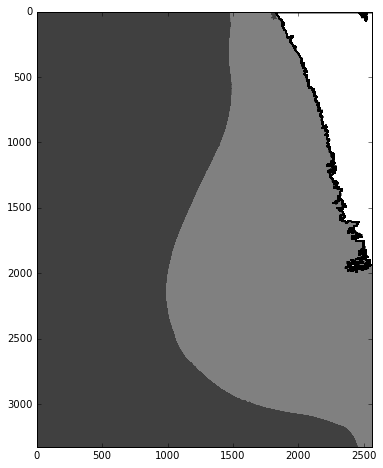

In [55]:
# Markers image for watershed algo.
pect_marker_img = np.zeros(pect_binary_thres.shape, dtype=np.int32)
# Sure foreground.
pect_mask_init = select_largest_obj(pect_binary_thres, lab_val=255, 
                                    fill_holes=True, smooth_boundary=False)
kernel_ = ones((3, 3), dtype=np.uint8)  # <<= para to tune!
n_erosions = 7  # <<= para to tune!
pect_mask_eroded = cv2.erode(pect_mask_init, kernel_, iterations=n_erosions)
pect_marker_img[pect_mask_eroded > 0] = 255
# Sure background - breast.
n_dilations = 7  # <<= para to tune!
pect_mask_dilated = cv2.dilate(pect_mask_init, kernel_, iterations=n_dilations)
pect_marker_img[pect_mask_dilated == 0] = 128
# Sure background - background.
pect_marker_img[mammo_breast_mask == 0] = 64
# plot.
fig,ax = subplots()
fig.set_size_inches([6, 9])
ax.imshow(pect_marker_img, cmap='gray')

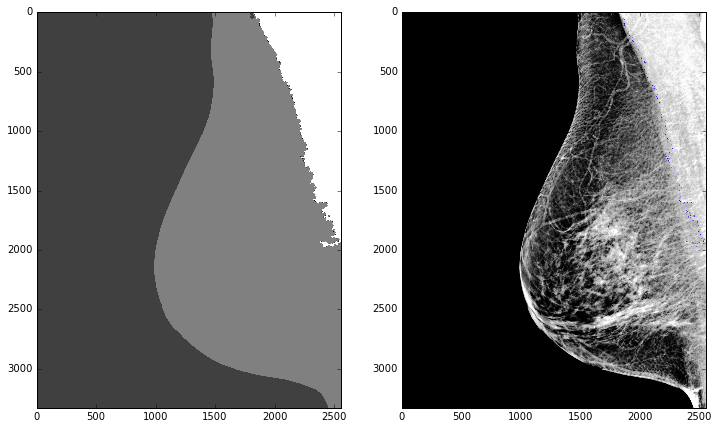

In [56]:
mammo_breast_equ_3c = cv2.cvtColor(mammo_breast_equ, cv2.COLOR_GRAY2BGR)
cv2.watershed(mammo_breast_equ_3c, pect_marker_img)
pect_mask_watershed = pect_marker_img.copy()
mammo_breast_equ_3c[pect_mask_watershed == -1] = (0, 0, 255)
pect_mask_watershed[pect_mask_watershed == -1] = 0
fig,axes = subplots(1, 2)
fig.set_size_inches([12, 9])
axes[0].imshow(pect_mask_watershed, cmap='gray')
axes[1].imshow(mammo_breast_equ_3c)

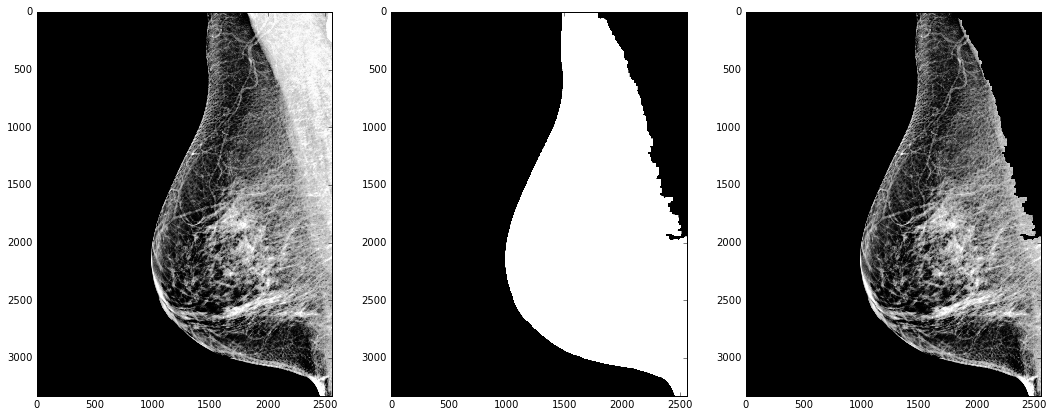

In [57]:
breast_only_mask = pect_mask_watershed.astype(np.uint8)
breast_only_mask[breast_only_mask != 128] = 0
breast_only_mask[breast_only_mask == 128] = 255
kn_size = 25  # <<= para to tune!
kernel_ = np.ones((kn_size, kn_size), dtype=np.uint8)
breast_only_mask_smo = cv2.morphologyEx(breast_only_mask, cv2.MORPH_OPEN, kernel_)
mammo_breast_only = cv2.bitwise_and(mammo_breast_equ, breast_only_mask_smo)
fig,axes = subplots(1, 3)
fig.set_size_inches([18, 9])
axes[0].imshow(mammo_breast_equ, cmap='gray')
axes[1].imshow(breast_only_mask_smo, cmap='gray')
axes[2].imshow(mammo_breast_only, cmap='gray')

## A preprocessing class

In [1]:
import cv2
mammo_org = cv2.imread('./trainingData/jpg/000138.jpg', 
                       cv2.IMREAD_GRAYSCALE)

In [2]:
from preprocess import DMImagePreprocessor
dm_img_pproc = DMImagePreprocessor()
mammo_pproc, mammo_col = dm_img_pproc.process(mammo_org)

/Users/lishen/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Populating the interactive namespace from numpy and matplotlib


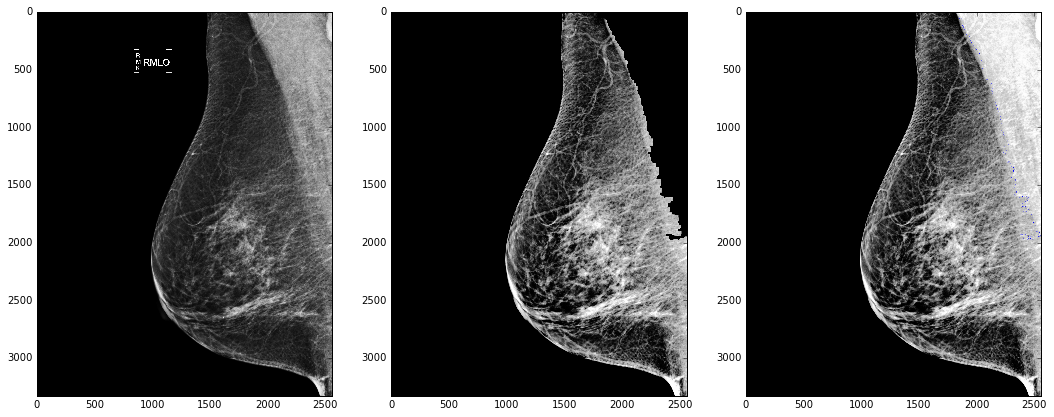

In [3]:
%pylab inline
fig,axes = subplots(1, 3)
fig.set_size_inches([18, 9])
axes[0].imshow(mammo_org, cmap='gray')
axes[1].imshow(mammo_pproc, cmap='gray')
axes[2].imshow(mammo_col)

In [5]:
mammo_artif_removed, breast_mask = dm_img_pproc.suppress_artifacts(mammo_org)

In [6]:
mammo_pectoral_removed, _ = dm_img_pproc.remove_pectoral(mammo_artif_removed, breast_mask)

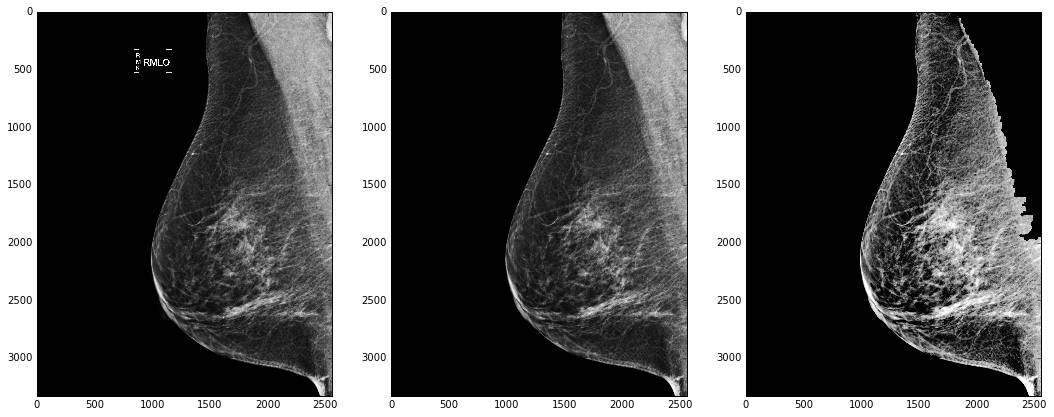

In [7]:
fig,axes = subplots(1, 3)
fig.set_size_inches([18, 9])
axes[0].imshow(mammo_org, cmap='gray')
axes[1].imshow(mammo_artif_removed, cmap='gray')
axes[2].imshow(mammo_pectoral_removed, cmap='gray')

/Users/lishen/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Populating the interactive namespace from numpy and matplotlib


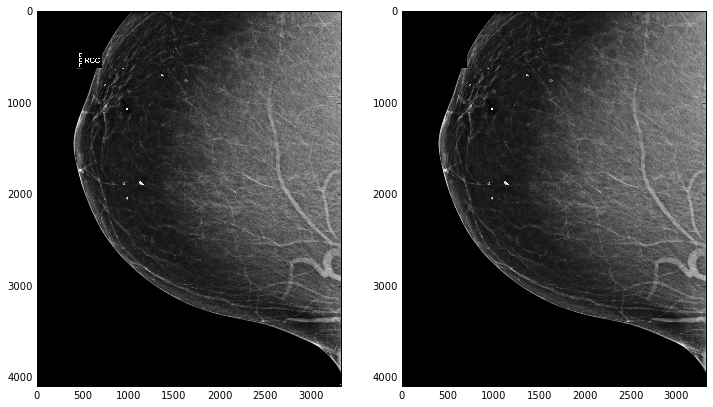

In [3]:
from preprocess import DMImagePreprocessor
import cv2
%pylab inline
dm_img_pproc = DMImagePreprocessor()
mammo_artif_breast = cv2.imread('./trainingData/jpg/121370.jpg', 
                                cv2.IMREAD_GRAYSCALE)
mammo_pproc,_ = dm_img_pproc.process(mammo_artif_breast, pect_removal=False)
fig,axes = subplots(1, 2)
fig.set_size_inches([12, 9])
axes[0].imshow(mammo_artif_breast, cmap='gray')
axes[1].imshow(mammo_pproc, cmap='gray')

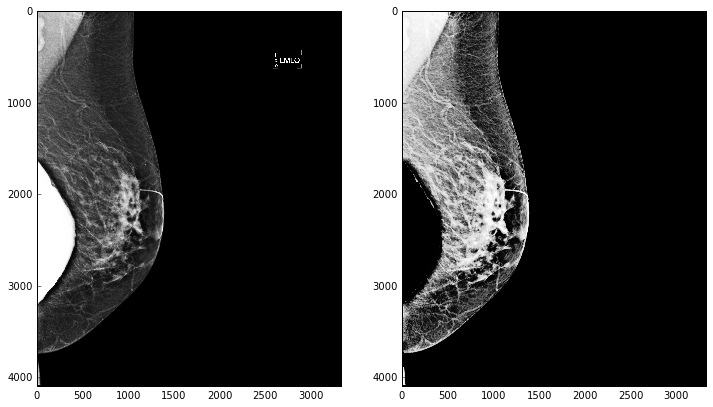

In [5]:
from preprocess import DMImagePreprocessor
import cv2
#%pylab inline
dm_img_pproc = DMImagePreprocessor()
mammo_org = cv2.imread('./trainingData/jpg/267624.jpg', cv2.IMREAD_GRAYSCALE)
mammo_pproc,_ = dm_img_pproc.process(mammo_org, pect_removal=True)
fig,axes = subplots(1, 2)
fig.set_size_inches([12, 9])
axes[0].imshow(mammo_org, cmap='gray')
axes[1].imshow(mammo_pproc, cmap='gray')

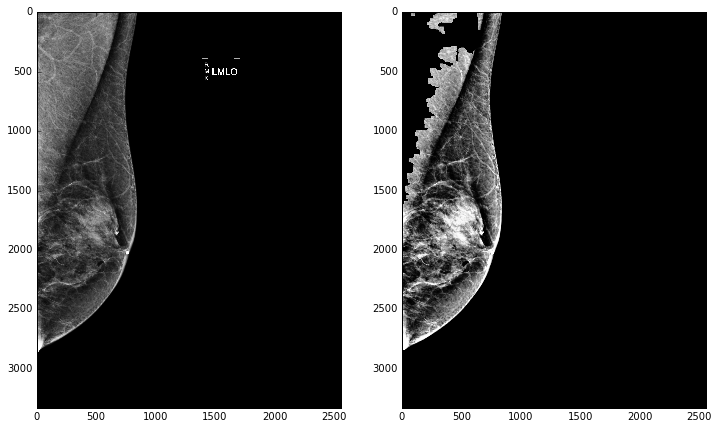

In [6]:
from preprocess import DMImagePreprocessor
import cv2
#%pylab inline
dm_img_pproc = DMImagePreprocessor()
mammo_org = cv2.imread('./trainingData/jpg/327015.jpg', cv2.IMREAD_GRAYSCALE)
mammo_pproc,_ = dm_img_pproc.process(mammo_org, pect_removal=True, high_int_threshold=100)
fig,axes = subplots(1, 2)
fig.set_size_inches([12, 9])
axes[0].imshow(mammo_org, cmap='gray')
axes[1].imshow(mammo_pproc, cmap='gray')

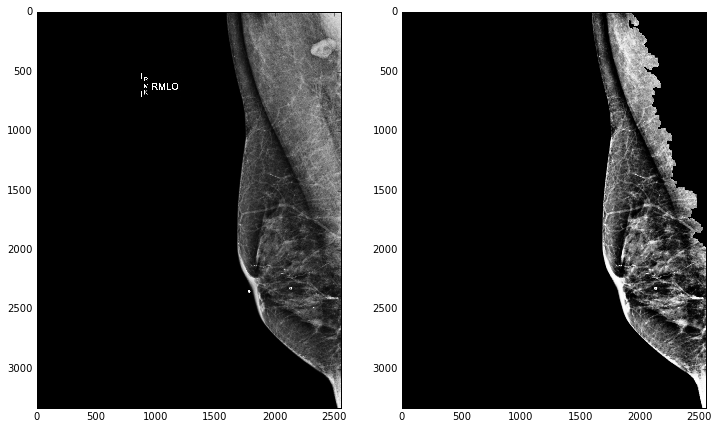

In [7]:
from preprocess import DMImagePreprocessor
import cv2
#%pylab inline
dm_img_pproc = DMImagePreprocessor()
mammo_org = cv2.imread('./trainingData/jpg/327017.jpg', cv2.IMREAD_GRAYSCALE)
mammo_pproc,_ = dm_img_pproc.process(mammo_org, pect_removal=True)
fig,axes = subplots(1, 2)
fig.set_size_inches([12, 9])
axes[0].imshow(mammo_org, cmap='gray')
axes[1].imshow(mammo_pproc, cmap='gray')

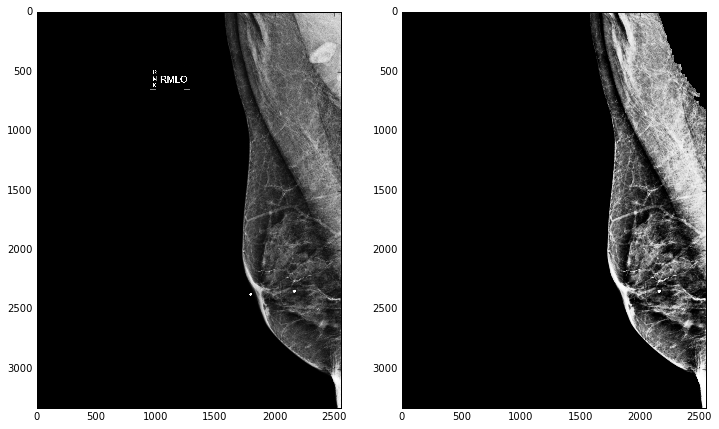

In [5]:
from preprocess import DMImagePreprocessor
import cv2
#%pylab inline
dm_img_pproc = DMImagePreprocessor()
mammo_org = cv2.imread('./trainingData/jpg/351994.jpg', cv2.IMREAD_GRAYSCALE)
mammo_pproc,_ = dm_img_pproc.process(mammo_org, pect_removal=True, high_int_threshold=50)
fig,axes = subplots(1, 2)
fig.set_size_inches([12, 9])
axes[0].imshow(mammo_org, cmap='gray')
axes[1].imshow(mammo_pproc, cmap='gray')

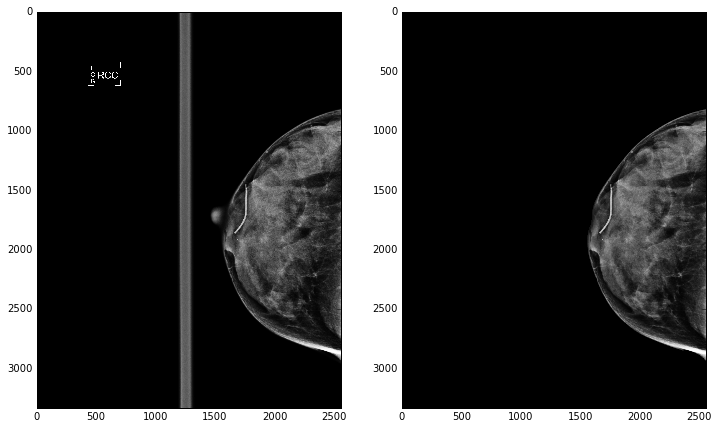

In [10]:
from preprocess import DMImagePreprocessor
import cv2
#%pylab inline
dm_img_pproc = DMImagePreprocessor()
mammo_org = cv2.imread('./trainingData/jpg/453532.jpg', cv2.IMREAD_GRAYSCALE)
mammo_pproc,_ = dm_img_pproc.process(mammo_org, pect_removal=False)
fig,axes = subplots(1, 2)
fig.set_size_inches([12, 9])
axes[0].imshow(mammo_org, cmap='gray')
axes[1].imshow(mammo_pproc, cmap='gray')

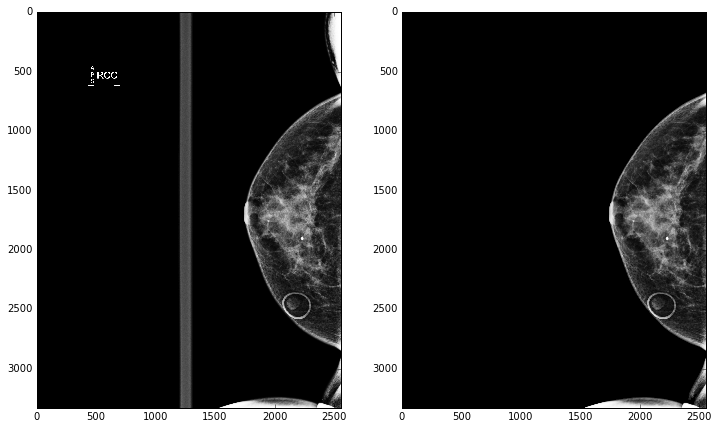

In [11]:
from preprocess import DMImagePreprocessor
import cv2
#%pylab inline
dm_img_pproc = DMImagePreprocessor()
mammo_org = cv2.imread('./trainingData/jpg/502858.jpg', cv2.IMREAD_GRAYSCALE)
mammo_pproc,_ = dm_img_pproc.process(mammo_org, pect_removal=False)
fig,axes = subplots(1, 2)
fig.set_size_inches([12, 9])
axes[0].imshow(mammo_org, cmap='gray')
axes[1].imshow(mammo_pproc, cmap='gray')